**02452** *Machine Learning*, Technical University of Denmark

- This Jupyter notebook contains exercises where you fill in missing code related to the lecture topic. *First*, try solving each task yourself. *Then* use the provided solution (an HTML file you can open in any web browser) as inspiration if needed. If you get stuck, ask a TA for help.

- Some tasks may be difficult or time-consuming - using the solution file or TA support is expected and perfectly fine, as long as you stay active and reflect on the solution.

- You are not expected to finish everything during the session. Prepare by looking at the exercises *before* the class, consult the TAs *during* class, and complete the remaining parts *at home*.

---

# Week 5: Bayesian inference and linear models

**Content:**
- Part 1: Linear Regression in 1D
- Part 2: Fitting non-linear data with Linear Regression in 1D
- Part 3: Linear regression on the Wine dataset
- Part 4: Logistic regression on the Wine dataset

**Objective:** become familiar with fitting linear regression models in Python.


In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import sklearn.linear_model as lm
import seaborn as sns

# Plotting style
sns.set_style('darkgrid')
sns.set_theme(font_scale=1.)

## Introduction

Regression is widely used in data mining and machine learning for predicting an output (dependent variable) for a data object given its attributes. Regression can be defined as the task of learning a target function that maps a set of attributes onto an output. In other words, regression is a *supervised learning* techniques that generalizes from known examples.

We will initially consider a linear regression problem with the goal of modeling the outputs, $\boldsymbol{y}=\left[y_1, y_2, \dots,  y_N\right]^\top$, based on a single attribute for each of $N$ data objects, $\boldsymbol{X}=\left[x_1, x_2, \dots, x_N\right]^\top$. To do this, we consider the model 
$$
\begin{equation*}
    y_n=w_0+w_1x_n+\epsilon_n,
\end{equation*}
$$
where $\epsilon_n$ is residual noise, $w_0$ a constant offset and $w_1$ the linear coefficient for $x_n$. We can write an equation for the target $y_n$ for each data object as
$$
\begin{aligned}
    y_1&=w_0+w_1x_1+\epsilon_1\\
    y_2&=w_0+w_1x_2+\epsilon_2\\
    &\qquad \qquad \vdots  \\
    y_N&=w_0+w_1x_N+\epsilon_N.\\
\end{aligned}
$$

We can think of the $n$'th equation as a vector product between the fixed true weight vector, $\boldsymbol{w} = \left[ w_0 , w_1 \right]^\top$, and the modified data point, $\tilde{\boldsymbol{x}}_n = \left [ 1, x_n \right ]^\top$. We can collect all modified data points in the matrix $\tilde{\boldsymbol{X}} = \left [ \bf{1} , \boldsymbol{x} \right ]$ where $\mathbf{1} = \left[ 1, 1, \dots , 1 \right]^\top$ is a vector of $N$ ones which allows us to compactly write the equations in matrix-vector form as
$$
\begin{equation*}
    \boldsymbol{y} = \tilde{\boldsymbol{X}} \boldsymbol{w} + \boldsymbol{\epsilon}
\end{equation*}
$$

--------------

## Part 1: Linear Regression in 1D  <a class="anchor" id="part1"></a>
First, we will consider fitting a simple linear regression model to 1-dimensional data generated by the following relation:
$$
    y_n = -0.5 + 0.01 \cdot x_n + \epsilon_n, \quad \epsilon_n \sim \mathcal{N}\left(0, 0.1\right)
$$

Each of the $n$ observations (having one attribute value $x_n$) should be set to $x_1\!\!=\!0, x_2\!\!=\!1,
x_3\!\!=\!2, \dots, x_N\!\!=\!N-1$ and $\epsilon_n$ describes the observation noise.

**Task 1.1:** Create a function `generate_data` that returns $N$ samples of this 1D dataset in the range $x\in[0,N-1]$. Plot the generated samples and the true noise-free function.
> *Hint*: You can use `np.arange` to make a sequence of integers.

> *Hint*: You can generate random numbers from a univariate Normal distribution using the function `np.random.normal`. 

> *Hint*: It’s a good idea to use `.reshape(-1, 1)` on `X`, `y` and `eps` to get row-vectors. This ensures compatible with the formulas from the course.

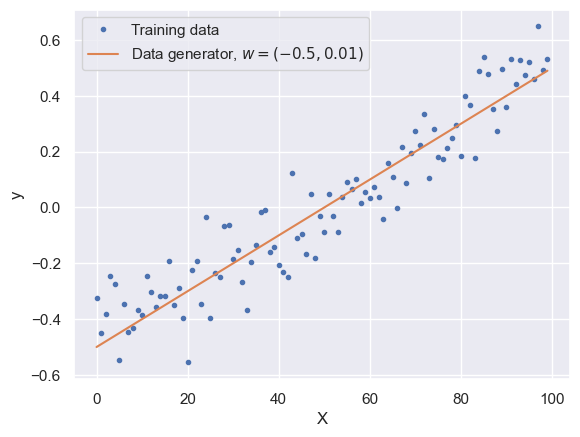

In [3]:
def generate_data(w=(-0.5, 0.01), N=100, eps_std=0.1, seed=0):
    np.random.seed(seed)

    ### BEGIN SOLUTION
    X = np.arange(N).reshape(-1, 1)                             # N attribute values from 0 to N-1
    eps = np.random.normal(0, eps_std, N).reshape(-1, 1) # noise from normal distribution
    y = (w[0] + w[1] * X + eps).reshape(-1, 1)                  # generated outputs based on the linear relation
    ### END SOLUTION

    return X, y, eps

# Plotting the generated data
N = 100                     # number of data objects
eps_std = 0.1               # observation noise parameter
w = (-0.5, 0.01)            # parameters of the linear relation

# Generate data with your function
X, y, eps = generate_data(eps_std=eps_std, w=w, N=N, seed=0)

# Get the true output values without noise
### BEGIN SOLUTION
y_true = w[0] + w[1] * X

# Or alternatively:
# y_true = y - eps
### END SOLUTION

# Plot original data and the model output
f = plt.figure()
plt.plot(X, y, ".", label="Training data")
plt.plot(X, y_true, "-", label=f"Data generator, $w={w}$")
plt.xlabel("X")
plt.ylabel("y")
plt.legend()
plt.show()

In general problems we would not know the true coefficients that generated the data. Our goal is therefore to *estimate* the coefficients, $w_0$ and $w_1$, from the data observations under the assumption that the data-generating process is linear. For doing so we minimize the least squares error function, i.e.
$$
\begin{equation*}
    \boldsymbol{w}^\ast = \begin{bmatrix} w_0^\ast \\ w_1^\ast \end{bmatrix} = \arg\min_{w_0, w_1} \sum_{n=1}^N \left(y_n-\left(w_0+w_1x_n\right)\right)^2=\arg\min_{w_0, w_1} \left\|\boldsymbol{y} - \tilde{\boldsymbol{X}} \boldsymbol{w} \right\|_F^2.
\end{equation*}
$$
Solving this optimization problem, the optimal parameter estimate has the closed-form expression
$$
    \boldsymbol{w}^\ast = \left(\tilde{\boldsymbol{X}}^\top \tilde{\boldsymbol{X}}\right)^{-1} \tilde{\boldsymbol{X}}^\top \boldsymbol{y}
$$
Based on the estimated parameters we can predict the value of an unobserved output $y^\ast$ from an observed measurement $x^*$ as
$$
\begin{equation*}
    y_\ast = \left[\begin{array}{c} 1 & x_\ast \end{array} \right] \left[  \begin{array}{c} w^\ast_0 \\ w^\ast_1\end{array} \right] = \boldsymbol{x}_\ast^\top \tilde{\boldsymbol{w}}^\ast
\end{equation*}
$$

**Task 1.2:** Fit a linear model to the data points and plot the estimated model on top of the data and true function.
> *Hint*: You can use the class `sklearn.linear_model.LinearRegression` as your model. Set `fit_intercept=True`, unless you added a column of 1's to your data matrix $\boldsymbol{X}$.

> *Hint*: Use method `fit()` to estimate parameters in the linear model and `predict()` to predict values for new data points.

> *Hint*: You can access the estimated parameters, $\boldsymbol{w^\ast}$, as `model.intercept_.item()`, `model.coef_.item()`.

**Optional:** Try to compute the estimated parameters with the closed-form expression. Do the two methods agree?

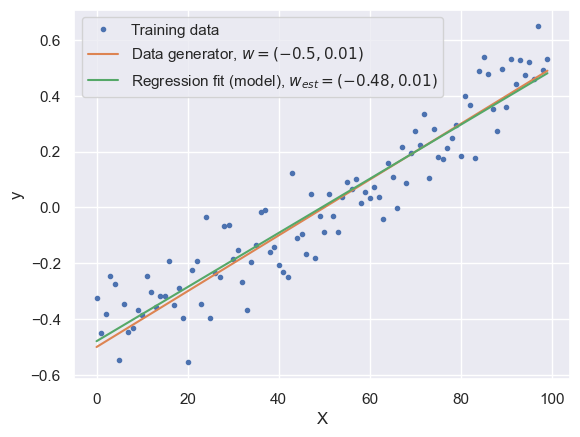

In [4]:
### BEGIN SOLUTION
model = lm.LinearRegression(fit_intercept=True)
model = model.fit(X, y)
y_est = model.predict(X)

# Or equivalently:
# y_est = model.intercept_ + X @ model.coef_

w_star = (model.intercept_.item(), model.coef_.item())
### END SOLUTION

# Plotting the generated data along with the true data generator and the estimated model
f = plt.figure()
plt.plot(X, y, ".")
plt.plot(X, y_true, "-")
plt.plot(X, y_est, "-")
plt.xlabel("X")
plt.ylabel("y")
plt.legend(["Training data", f"Data generator, $w={w}$", f"Regression fit (model), $w_{{est}}=({round(w_star[0],2)}, {round(w_star[1],2)})$"])
plt.show()

**Task 1.3:** Explain how the model estimates the parameters, $w_0$ and $w_1$, from the data you have generated.

- *Answer:*

**Task 1.4:** Explain why the estimated parameters are close, but not exactly equal, to the parameters used to generate the data.

- *Answer:*


**Task 1.5:** Go back and play around with the number of data samples, `N`, and the noise variance, `eps_std`. How can you get the estimated model parameters closer to the actual parameters used to generate the data?

<br>

----------

## Part 2: Fitting non-linear data with Linear Regression in 1D  <a class="anchor" id="part2"></a>

Sometimes there are more complex relationships between the attributes and output. In order to capture more complex relationships we can include attributes that are specified transformations of existing attributes such as $\sqrt{x}$, $\log{(x)}$, $x^2$ and $x^3$. 

We will presently consider the model

\begin{equation*}
y_n = w_0 + \sum_{k=1}^{K} w_k x_n^k + \epsilon_n
\end{equation*}

The above model can again be written for all $N$ observations simultaneously in terms of vectors and matrices, i.e.

$$
\boldsymbol{y} = \left[\boldsymbol{1}\ \boldsymbol{x}^1\ \boldsymbol{x}^2\ \dots\ \boldsymbol{x}^{K}\right]
\begin{bmatrix}
    w_0 \\
    w_1 \\
    w_2 \\
    \vdots \\
    w_{K}
\end{bmatrix}
+ \boldsymbol{\epsilon}
= \left[\boldsymbol{1}\ \boldsymbol{X}\right] \boldsymbol{w} + \boldsymbol{\epsilon}
$$

where $\boldsymbol{x}^{k}=\left[ x_1^{k}, x_2^{k}, \dots, x_N^{k}\right]^\top$.

<br>

**Task 2.1:** Create a function `generate_data` that returns $N$ samples of this dataset in the range $x\in[-2,2]$. The function should allow you to specify how many $K$ terms to include (squared, cubed, etc.) for generating the data.
> *Hint*: You can use `np.linspace()` to make a sequence of real numbers.

> *Hint*: See the function `np.power()` that can raise the content of a vector/matrix to a specified order.

**Task 2.2:** Generate $N=50$ samples with $\boldsymbol{w} = -\begin{bmatrix}-0.9 & -0.9^2 & \dots & -0.9^{K+1}\end{bmatrix}^\top$ for $K=5$. Plot the generated samples and the true function in the range $x\in[-2,2]$ with a higher resolution on the x-axis.  

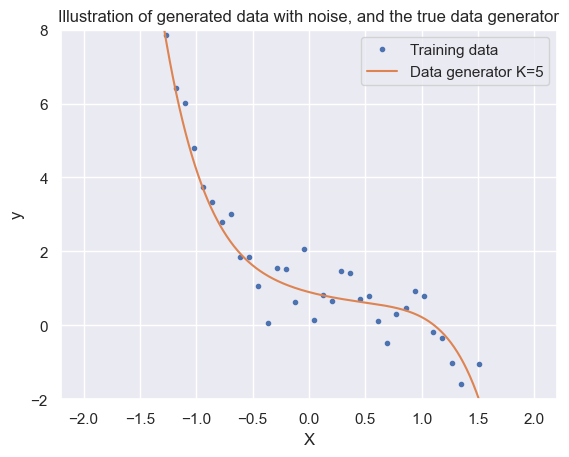

In [ ]:
def generate_polynomial_data(w, K_data, eps_std, seed=0):
    np.random.seed(seed)

    ### BEGIN SOLUTION

    # Generate dataset (with noise)
    X = np.linspace(-2, 2, N).reshape(-1, 1)            # column vector of shape (N, 1)
    # Apply polynomial transformation to X
    X_transformed = np.power(X, range(1, K_data + 1))   # each column is X to the power of 1, 2, ..., K_data

    # Why K + 1? Because w includes the intercept term w[0]

    # Generate noise
    eps = eps_std * np.random.randn(N)  # noise from normal distribution N(0, eps_std^2) of shape (N,) = column vector (N, 1)
    
    # Generate outputs based on the linear relation
    y = w[0] + X_transformed @ w[1:] + eps
    ### END SOLUTION

    return X, y, eps


# Parameters
N = 50                      # no of data objects to train a model
K_data = 5                  # no of terms for data generator
eps_std = 0.5  # noise parameters

# Define the true parameter vector
### BEGIN SOLUTION
w_true = -np.power(-0.9, range(1, K_data + 2)) # (K_data + 1,) shape, w[0] is intercept
### END SOLUTION

# Generate data with your function
X, y, eps = generate_polynomial_data(w=w_true, K_data=K_data, eps_std=eps_std, seed=0)

# Sampling 1000 points to visualize the true data and model
N_est = 1000
X_est = np.linspace(-2, 2, 1000).reshape(-1, 1) # 'continueous' range of X values for visualization

# Define the true data generator function, y_true (assuming no noise)
### BEGIN SOLUTION
Xde = np.power(X_est, range(1, K_data + 1))
y_true = w_true[0] + Xde @ w_true[1:]
### END SOLUTION

# Plot original data and the model output
f = plt.figure()
plt.title("Illustration of generated data with noise, and the true data generator")
plt.plot(X, y, ".", label="Training data")
plt.plot(X_est, y_true, "-", label=f"Data generator K={K_data}")
plt.xlabel("X")
plt.ylabel("y")
plt.ylim(-2, 8)
plt.legend()
plt.show()

We now want to fit a model with polynomial terms of order $K_{m}$ to the data generated above. The models output can be formulated as
$$
\begin{equation*}
    y_n = w^\ast_0 + \sum_{k=1}^{K_m} w^\ast_k x_n^k \qquad 
    \text{or} \qquad 
    \boldsymbol{y} = \tilde{\boldsymbol{X}} \boldsymbol{w}^\ast
\end{equation*}
$$
for $N$ observations where $\tilde{\boldsymbol{X}} = \left[\boldsymbol{1}, \boldsymbol{x}, \boldsymbol{x}^2, \dots, \boldsymbol{x}^{K_m} \right]$. Remark the difference between the order of the model, $K_m$, and the order of the data, $K$. This model can fit non-linear trend of the data but is *still linearly dependent on the model weights*. The overall formulation is therefore exactly the same as before for which we know how to compute the coefficients.

<br>

**Task 2.2:** Estimate the model parameters for a model with polynomial order of $K_{m} = 3$. Plot the estimated model on top of the generated data samples and true model.
> *Hint*: Create a matrix `X_tilde` and use it for model fitting. 

> *Hint*: Create a matrix `X_est_tilde` and use it for model prediction. 

> *Hint:* Consider stacking the model parameters in a vector using `np.hstack()`.

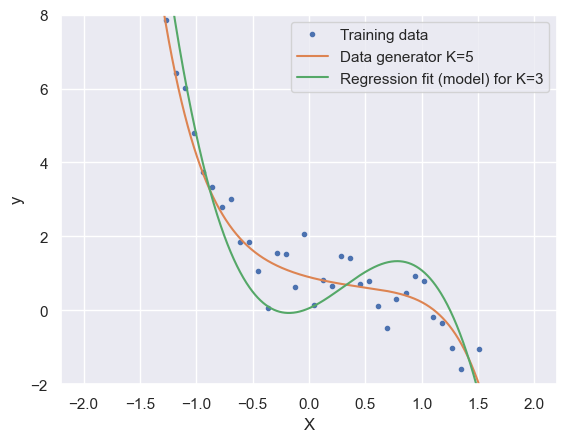

Estimated parameters: [ 0.05584024  1.32478325  2.8621672  -3.16053618]


In [9]:
K_model = 3

# Fit the model with polynomial features up to degree K_model and estimate the outputs as y_est
### BEGIN SOLUTION

# Create polynomial features up to degree K_model
X_tilde = np.power(X, range(1, K_model + 1))
X_est_tilde = np.power(X_est, range(1, K_model + 1))

# Fit the linear regression model
model = lm.LinearRegression(fit_intercept=True) 
# ! fit_intercept=True because X does not include a column of ones for the intercept term
model = model.fit(X_tilde, y)
w_star = np.hstack([model.intercept_, model.coef_.flatten()])  # Estimated parameters in a single array of size (K_model + 1,)

# Predict values
y_est = model.predict(X_est_tilde)

### END SOLUTION

# Plot original data and the model output
f = plt.figure()
plt.plot(X, y, ".", label = "Training data")
plt.plot(X_est, y_true, "-", label = f"Data generator K={K_data}")
plt.plot(X_est, y_est, "-", label = f"Regression fit (model) for K={K_model}")
plt.xlabel("X")
plt.ylabel("y")
plt.ylim(-2, 8)
plt.legend()
plt.show()

print(f"Estimated parameters: {w_star.flatten()}")

**Task 2.3:** Play around with the parameters of the experiment and reflect on how they impact the model fit.
- How well does the model fit the data points? How well does the model fit the true underlying function?

- What happens when fitting a model with more higher order terms, e.g. $K_m=10$ or $K_m=25$? Do you see any potential problems when setting $K_m$ too high?

- Try increasing the number of samples to $N=1000$ while keeping the $K_m=25$. How does this impact the model fit? How did this impact the potential problem?

<br>

----------

## Part 3: Linear regression on the Wine dataset <a class="anchor" id="part3"></a>

We will now take a look at the wine data set and attempt to predict the alcohol content (given in percentage) using linear regression. The linear regression model we consider is

$$
\begin{equation*}
    y_n=w_0+\sum_k w_kx_{n,k}+\epsilon_n,
\end{equation*}
$$
where $y_n$ is the observed alcohol content, $\epsilon_n$ the model residual, $w_k$ the value of the estimated model coefficient for the $k^{th}$ attribute, whereas $x_{n,k}$ denotes the $n^{th}$ observation of the $k^{th}$ attribute. As such, $x_{2,1}$ denotes the second observation of the first attribute (Fixed acidity) and $x_{5,2}$ the fifth observation of the second attribute (Volatile acidity). 

Say we expect volatide acidity (VA) to be around $0-2 \textrm{g}/\textrm{dm}^3$, density (D) to be close to $1 \textrm{g}/\textrm{cm}^3$, and alcohol percentage (AP) to be somewhere between $5-20\% \textrm{vol}$. We can use this knowledge to define wines with VA > 2, D > 1 and AP > 20 as outliers.

**Task 3.1:** Load the Wine dataset in Pandas from the accompanied data-folder and take a look at the data structure. Remove the `"Quality score (0-10)"`-column as well as potential outliers.

> *Hint:* Use `pd.read_csv`, `df.drop()` and `df.head()`

> *Hint:* Pandas allows for logical conditions like `(df['Alcohol'] > 20)` to identify rows with outliers. Combine multiple conditions using the `|` operator (logical OR), and wrap each condition in parentheses. To remove the outliers, consider using the `~` operator to invert the filter.

In [10]:
# Load the wine dataset in pandas DataFrame
### BEGIN SOLUTION

df = pd.read_csv('data/wine.csv')
df = df.drop(columns=['Quality score (0-10)'])

# Filter outliers based on the defined rules
df = df[~((df['Volatile acidity'] > 2) | (df['Density'] > 1) | (df['Alcohol'] > 20))]
### END SOLUTION

print(df.shape)
df.head()

(6304, 12)


,Fixed acidity,Volatile acidity,Citric acid,Residual sugar,Chlorides,Free sulfur dioxide,Total sulfur dioxide,Density,pH,Sulphates,Alcohol,Color
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,Red
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,Red
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,Red
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,Red
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,Red


Originally the dataset is used for binary classification on red vs. white wines, which we will also be doing with logistic regression in Part 4. For now we will consider the `Alcohol` content as our target attribute and perform a linear regression using the remaining attributes.

**Task 3.3:** Pick the correct columns of the dataframe, to construct your `X` and `y` matrices containing input attributes and target attributes for the task.

In [11]:
### BEGIN SOLUTION
X = df.drop(columns=['Alcohol', 'Color'])
y = df['Alcohol']
### END SOLUTION

**Task 3.4:** Fit a linear model of the data points and calculate the residuals. Collect the estimated parameters in a vector (as previously) and plot the estimated model.

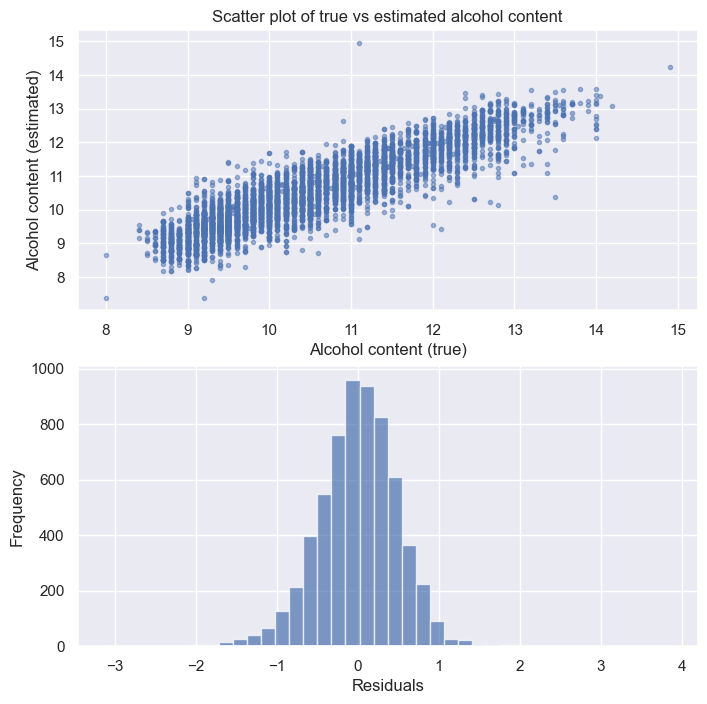

Estimated parameters:
Fixed acidity: 622.356
Volatile acidity: 0.584
Citric acid: 1.319
Residual sugar: 0.322
Chlorides: 0.208
Free sulfur dioxide: 0.405
Total sulfur dioxide: 0.001
Density: -0.005
pH: -631.055
Sulphates: 2.981

MSE: 0.249


In [12]:
# Fit regression model to the wine dataset
### BEGIN SOLUTION

# Fit the linear regression model
model = lm.LinearRegression(fit_intercept=True)
model.fit(X, y)
# Estimated parameters (intercept and coefficients)
w_star = np.hstack([model.intercept_, model.coef_.flatten()])  # Estimated parameters

# Predict alcohol content
y_est = model.predict(X)
# Calculate residuals
residual = y_est - y

### END SOLUTION

# Display scatter plot and histogram of residuals
fig, axs = plt.subplots(2, 1, figsize=(8, 8))
axs[0].scatter(y, y_est, marker='.', alpha=0.5)
axs[0].set_xlabel("Alcohol content (true)")
axs[0].set_ylabel("Alcohol content (estimated)")
axs[0].set_title("Scatter plot of true vs estimated alcohol content")
axs[1].hist(residual, bins=40, alpha=0.7)
axs[1].set_xlabel("Residuals")
axs[1].set_ylabel("Frequency")
plt.show()

# Estimated parameters, and their attribute names
print("\033[1mEstimated parameters:\033[0;0m")      # Bold text for emphasis
for i, name in enumerate(X.columns):
    print(f"{name}: {w_star[i].item():.3f}")

print(f"\nMSE: {np.mean(residual**2):.3f}")

**Task 3.5** Explain how the visualizations show that the alcohol content can be predicted with an accuracy of approximately $\pm 1$ percentage point.

- *Answer:*

**Task 3.6:** Argue from the estimated parameters of the linear regression model that wines with higher alcohol content in general have lower density. Consider verifying it with a small code example.

- *Answer:*

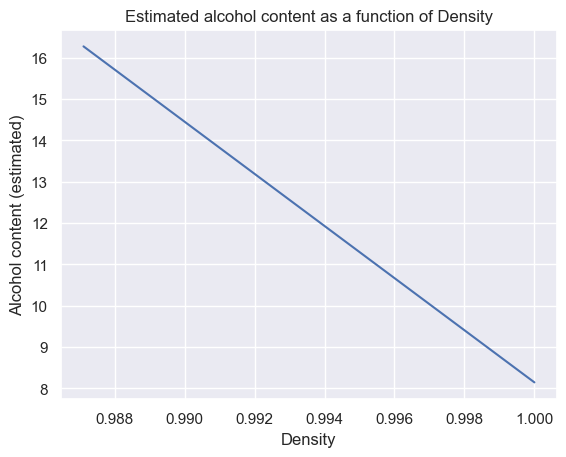

In [13]:
### BEGIN SOLUTION
# Can be inferred directly from the estimated parameter of Density being negative

# But we can also visualize it, by taking a random Wine from the dataset, and varying it's density attribute.
example = X.iloc[0, :]
# Create a dataframe with many copies of the example
example = pd.DataFrame([example] * 100, columns=X.columns)
# Define a realistic density range
density_vals = np.linspace(X['Density'].min(), X['Density'].max(), 100)
# replace the dummy density attribute with the range
example['Density'] = density_vals.flatten()

# Plot the estimated alcohol content as a function of Density
fig = plt.figure()
plt.title("Estimated alcohol content as a function of Density")
plt.plot(density_vals, model.predict(example))
plt.xlabel("Density")
plt.ylabel("Alcohol content (estimated)")
plt.show()
### END SOLUTION

**Task 3.7:** Go back to where you defined your data matrix `X`. How does the following affect the performance of your linear regression model?
- Standardization of the input attributes.
- Standardization of the target attribute.
- Adding a new feature that is pure noise.
- Adding a new feature that is very similar to an existing one. E.g. do `X['new-pH'] = X['pH'] + 0.01 * np.random.randn(X.shape[0])`

As we saw in Part 2, specific data attributes can have a non-linear relationship with the output and we need to consider if specific transformations of attributes can capture such non-linear patterns effectively. For determining if there are any obvious transformations, we take a closer look at the wine data set.

**Task 3.8:** Create a figure with subplots that shows each attribute against the alcohol content as scatter plots. Create a similar figure showing each attribute against the model residual.

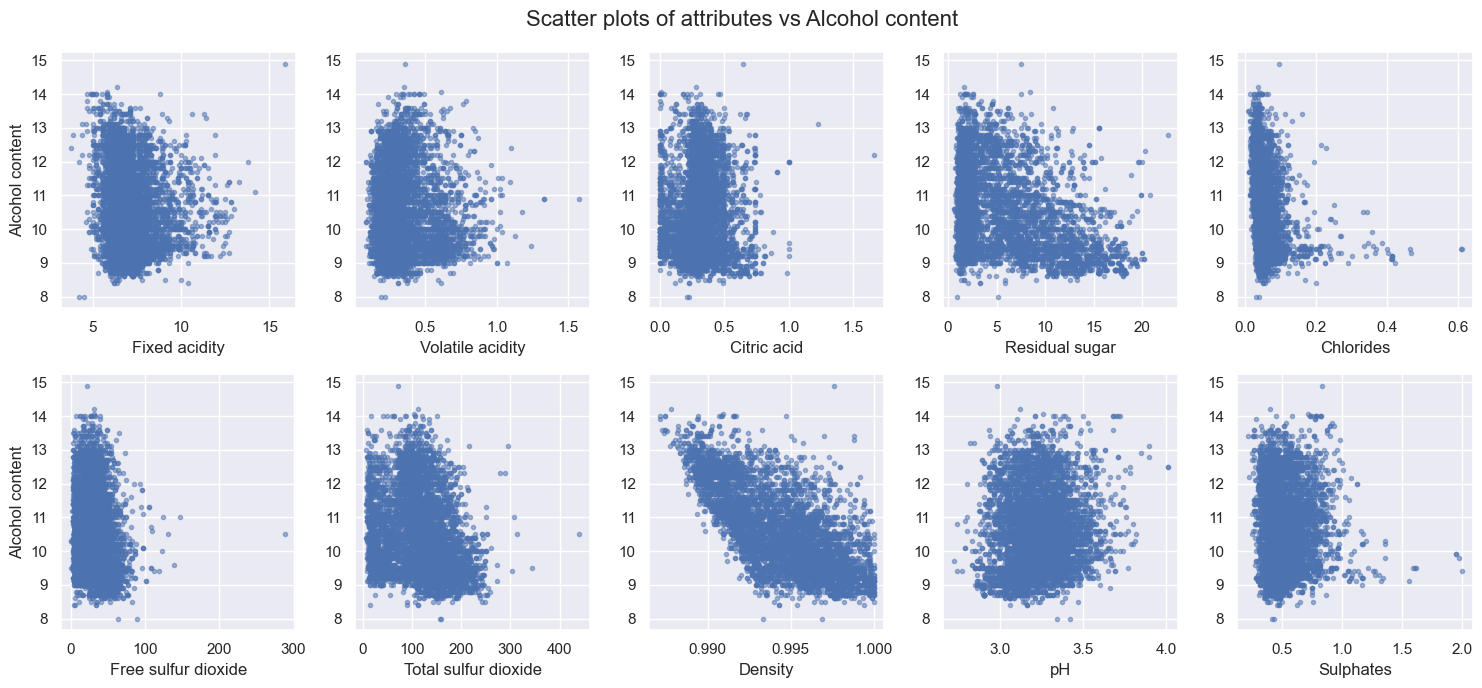

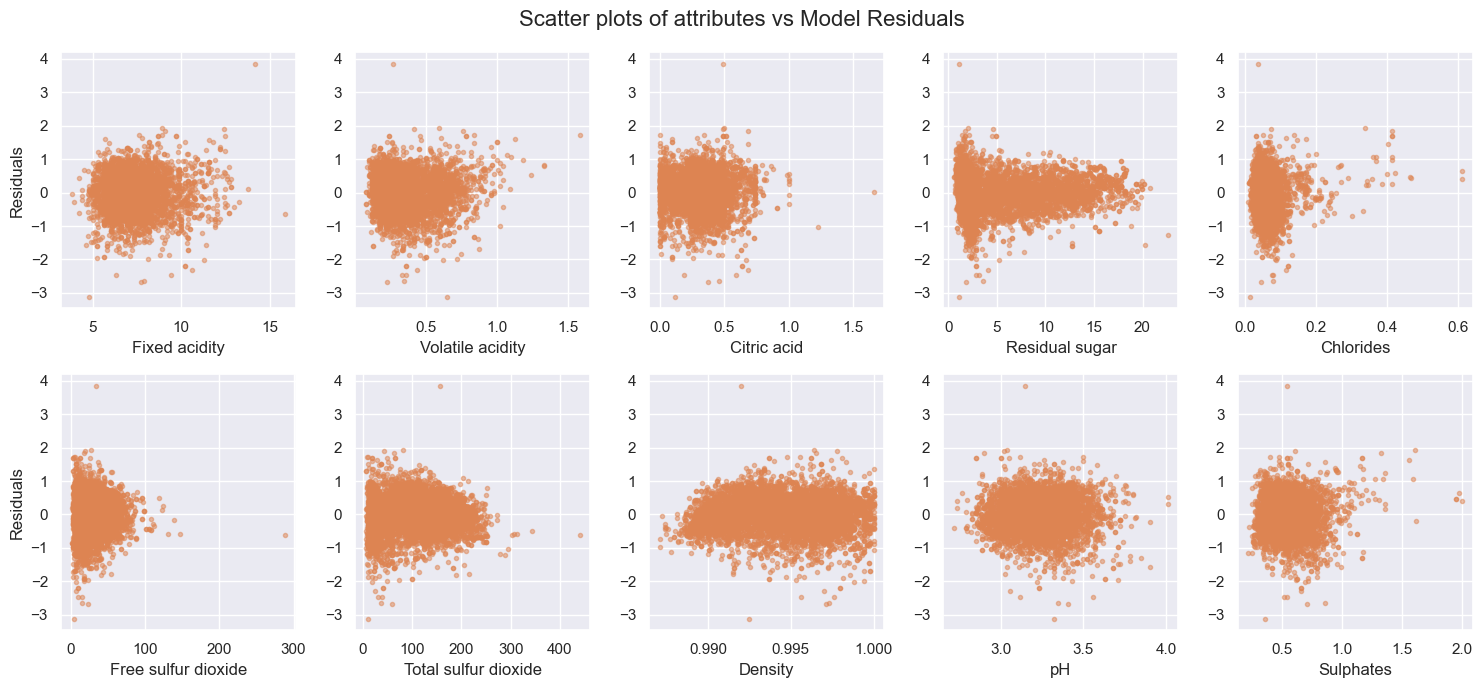

In [14]:
### BEGIN SOLUTION 
# Plot a scatter plot with all attributes in X against the alcohol content
fig, axs = plt.subplots(2, len(X.columns) // 2, figsize=(15, 7))
fig.suptitle("Scatter plots of attributes vs Alcohol content", fontsize=16)
for i, attribute in enumerate(X.columns):
    # Determine the row and column for the subplot
    row, col = divmod(i, len(X.columns) // 2)
    # Plot the scatter plot
    axs[row, col].scatter(X[attribute], y, marker='.', alpha=0.5)
    axs[row, col].set_xlabel(attribute)
    # Add y label only to the first column
    if col == 0:
        axs[row, col].set_ylabel("Alcohol content")
plt.tight_layout()
plt.show()

# Plot a scatter plot with all attributes in X against the model residuals
fig, axs = plt.subplots(2, len(X.columns) // 2, figsize=(15, 7))
fig.suptitle("Scatter plots of attributes vs Model Residuals", fontsize=16)
for i, attribute in enumerate(X.columns):
    # Determine the row and column for the subplot
    row, col = divmod(i, len(X.columns) // 2)
    # Plot the scatter plot
    residual = y_est.flatten() - y  # Calculate residuals
    axs[row, col].scatter(X[attribute], residual, marker='.', alpha=0.5, color='C1')
    axs[row, col].set_xlabel(attribute)
    # Add y label only to the first column
    if col == 0:
        axs[row, col].set_ylabel("Residuals")
plt.tight_layout()        
plt.show()
### END SOLUTION

**Task 3.9:** Argue what transformations could be useful for making the linear assumption of the regression model more appropriate. Construct a new data matrix `X_tilde` based on your thoughts and fit a linear regression model to the transformed wine data. Compute the mean-squared error (MSE) and plot each transformed attribute vs. the residual as scatter plots.

> *Hint*: Feel free to iterate - how low can you get the MSE?

> *Hint*: Plots of attributes versus the model residuals can help reveal if there is structure in the output that can be explained by transformations of the attributes.

> *Hint*: You can use `np.log()`, `np.power()`, `np.multiply()`, etc. on appropriate columns of data matrix.

> *Hint*: The `np.bmat()` function is useful to concatenate matrices and/or vectors.

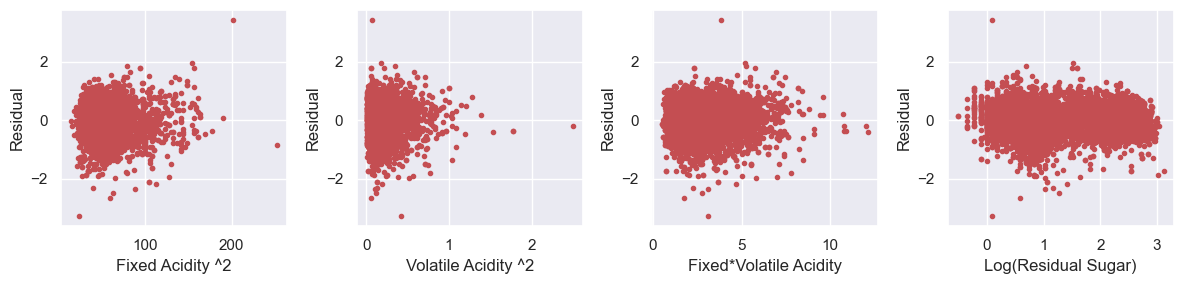

MSE: 0.23536901978726962


In [16]:
### BEGIN SOLUTION
# Construct additional attributes
Xfa2 = np.power(df['Fixed acidity'], 2).values.reshape(-1, 1)                   # make a column vector for FA^2
Xva2 = np.power(df['Volatile acidity'], 2).values.reshape(-1, 1)                # make a column vector for VA^2
Xfava = (df['Fixed acidity'] * df['Volatile acidity']).values.reshape(-1, 1)    # make a column vector for FA*VA
Xrslog = np.log(df['Residual sugar']).values.reshape(-1, 1)                     # make a column vector for log(RS)

# Update the feature matrix to include additional attributes
# -> we don't update X, but create a new matrix X_tilde
X_tilde = np.asarray(np.bmat("X, Xfa2, Xva2, Xfava, Xrslog"))  

# Fit ordinary least squares regression model
# only using the new attributes
model = lm.LinearRegression()
model.fit(X_tilde, y)

# Predict alcohol content
y_est = model.predict(X_tilde)
residual = y_est - y

# Display plots
fig, axs = plt.subplots(1, 4, figsize=(12, 3))
axs[0].scatter(Xfa2, residual, marker='.', color='r')
axs[0].set_xlabel("Fixed Acidity ^2")
axs[0].set_ylabel("Residual")
axs[1].scatter(Xva2, residual, marker='.', color='r')
axs[1].set_xlabel("Volatile Acidity ^2")
axs[1].set_ylabel("Residual")
axs[2].scatter(Xfava, residual, marker='.', color='r')
axs[2].set_xlabel("Fixed*Volatile Acidity")
axs[2].set_ylabel("Residual")
axs[3].scatter(Xrslog, residual, marker='.', color='r')
axs[3].set_xlabel("Log(Residual Sugar)")
axs[3].set_ylabel("Residual")
plt.tight_layout()
plt.show()

print("MSE:", np.mean(residual**2))
### END SOLUTION

---

## Part 4: Logistic regression on the Wine dataset <a class="anchor" id="part4"></a>

Until now we have discussed the most simple linear model based on the squared error cost function. In the generalized linear model, we can also use other cost functions as well as non-linear link functions. 

The cost function of a general linear model can be defined as
$$
E(\boldsymbol{w}) = - \sum_{i=1}^N d(y_i, g(\tilde{\boldsymbol{x}}_i^\top \boldsymbol{w}))
$$
With:
$$\begin{align}
d(a,b) & = \textbf{The cost function} \text{ measuring the dissimilarity between } a \text{ and } b. \\
g(x) & = \textbf{The link function}
\end{align}$$

It can be very useful to limit the possible outputs to the range $(0,1)$ if the outputs we wish to predict are binary. Predicting binary outputs is what we have previously referred to as binary classification and generalized linear models can thus both be used for regression and classification. 

### Link function for Logistic Regression

For outputs that are purely binary, $y\in\{0,1\}$, we can use the logistic function,$$g(x) = \sigma(x)=\frac{1}{1+\exp(-x)}$$as the non-linear link function. This function maps the output in the regression analysis to the range $(0,1)$ and ensures that $$\sigma(x) = 1 - \sigma(x)$$You can read more about the logistic function [here](https://en.wikipedia.org/wiki/Logistic_function).

### Cost function for Logistic Regression

The cost function for logistic regression is based on the binomial distribution and can be written as
$$
E(\boldsymbol{w}) = - \sum_{i=1}^N \left[ y_i \log(\theta_i) + (1 - y_i) \log\left(1 - \theta_i \right) \right] = - \sum_{i=1}^N d(y_i, \theta_i)
$$
So
$$
d(y,z) = y \log(z) + (1 - y) \log(1 - z)
$$


**Task 4.1:** Plot the logistic link function in the range $x\in\left[-5, 5\right]$.

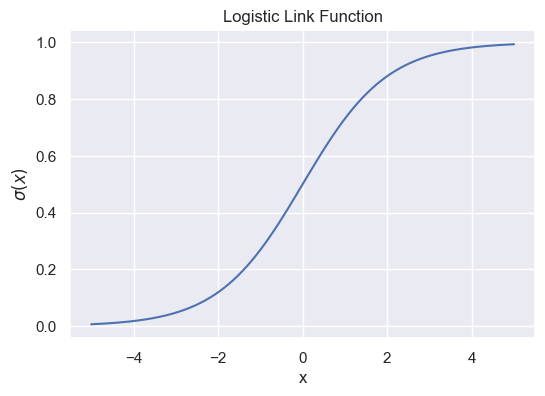

In [18]:
### BEGIN SOLUTION
xaxis = np.linspace(-5, 5, 1000).reshape(-1, 1)

fig = plt.figure(figsize=(6, 4))
plt.plot(xaxis, 1 / (1 + np.exp(-xaxis)))
plt.xlabel("x")
plt.ylabel(r"$\sigma(x)$")
plt.title("Logistic Link Function")
plt.show()
### END SOLUTION

Classification with a binomial cost function and logistic link function is called *logistic regression* (for more information [see here](https://en.wikipedia.org/wiki/Logistic_regression)), and is implemented in Python with the module `sklearn.linear_model.logistic.LogisticRegression`.

We will return to the wine data and predict the type of wine using logistic regression. The model we consider is
$$
    y_n=\sigma\left(w_0+\sum_k w_k x_{n, k}\right)+\epsilon_n
$$
where $y_n$ is the observed type of wine (Red: $y_n=0$ and White: $y_n=1$). We will say that a wine is White with probability $p$ and Red with probability $1-p$. where $p=\sigma(w_0+\sum_k w_k x_{n,k})$.

**Task 4.2:** Construct the data matrices `X` and `y` so that they are suitable for solving the binary classification problem.
> *Hint:* You previously loaded the data set using Pandas, so all you need to do is pick the correct columns.

In [19]:
# Construct X and y for the classification problem
### BEGIN SOLUTION
X = df.drop(columns=['Color'])
y = df['Color'].values
### END SOLUTION

**Task 4.3:** Fit a logistic regression model on `X`, and predict the labels, `y_est`, and the predicted probabilities of the observation being a white wine, `y_est_white_prob`.

> *Hint*: To estimate a logistic regression model, use the class: `sklearn.linear_model.logistic.LogisticRegression`.

> *Hint*: Use the method `.predict()` to get predictions from your estimated model. Use `.predict_proba()` to get the probability of a data point belonging to the postivie class, i.e. $p\left(y_n=1|x_n\right)$.

**Task 4.2:** Compute the misclassification rate, `misclass_rate`. How does this relate to the accuracy?

y (first 10): ['Red' 'Red' 'Red' 'Red' 'Red' 'Red' 'Red' 'Red' 'Red' 'Red']
y_est (first 10): ['Red' 'Red' 'Red' 'Red' 'Red' 'Red' 'Red' 'Red' 'Red' 'Red']
y_est_white_prob (first 10): [0.00095556 0.00167785 0.00298118 0.01869965 0.00095556 0.00172212
 0.02840708 0.00309733 0.00188048 0.27529108]
y_est != y (first 10): [False False False False False False False False False False]

Overall misclassification rate: 0.0141


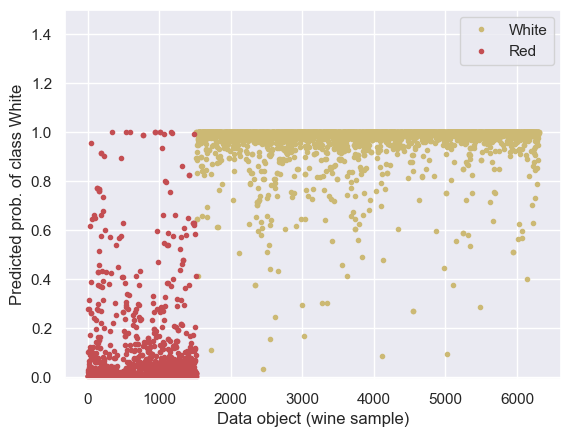

In [29]:
# Fit the logistic regression model, and define y_est and y_est_white_prob
### BEGIN SOLUTION
# Fit the logistic regression model
model = lm.LogisticRegression(max_iter=1000)
model = model.fit(X, y)

# Classify wine as Red/White (0/1) and assess probabilities
y_est = model.predict(X)
y_est_white_prob = model.predict_proba(X)[:, 1]

print(f"y (first 10): {y[:10]}")
print(f"y_est (first 10): {y_est[:10]}")
print(f"y_est_white_prob (first 10): {y_est_white_prob[:10]}")
print(f"y_est != y (first 10): {(y_est != y)[:10]}")
### END SOLUTION

# Evaluate classifier's misclassification rate over entire training data
### BEGIN SOLUTION
misclass_rate = np.sum(y_est != y) / float(len(y_est))
### END SOLUTION

# Display classification results
print("\nOverall misclassification rate: {0:.4f}".format(misclass_rate))

f = plt.figure()
class0_ids = np.nonzero(y == "White")[0].tolist()
plt.plot(class0_ids, y_est_white_prob[class0_ids], ".y")
class1_ids = np.nonzero(y == "Red")[0].tolist()
plt.plot(class1_ids, y_est_white_prob[class1_ids], ".r")
plt.xlabel("Data object (wine sample)")
plt.ylabel("Predicted prob. of class White")
plt.legend(["White", "Red"])
plt.ylim(-0.01, 1.5)
plt.show()

**Task 4.3:** What is visualized in the plot above?

- *Answer:* 

**Task 4.4:** Use the model to show that the following newly observed wine, would be classified as White wine with more than 90\% probability.
- Fixed acidity: 6.9
- Volatile acidity: 1.09
- Citric acid: 0.06
- Residual sugar: 2.1
- Chlorides: 0.0061
- Free sulfur dioxide: 12.0
- Total sulfur dioxide: 31.0
- Density: 0.99
- pH: 3.5
- Sulphates: 0.44
- Alcohol: 12.0

> *Hint:* Models from `sklearn` can work directly with Pandas dataframes, just make sure that you always input data frames with identical columns.

In [ ]:
# Define the new wine, and evaluate its probability of being a white wine.
### BEGIN SOLUTION
x = pd.DataFrame([[6.9, 1.09, 0.06, 2.1, 0.0061, 12, 31, 0.99, 3.5, 0.44, 12]], columns=X.columns)
# Evaluate the probability of x being a white wine (class=0)
x_proba = model.predict_proba(x)[0, 0]
### END SOLUTION

print(f"Probability of given sample being a white wine: {x_proba:.4f}")

**Task 4.5:** Go back to where you defined your data. How does the following affect the performance of your logistic regression model?
- Standardization of the input features.
- Adding a feature that is pure noise
- Adding a feature that is very similar to an existing one. E.g. do `X['new-pH'] = X['pH'] + 0.01 * np.random.randn(X.shape[0])`